# Business Problem

Your company now sees all the big companies creating original video content and they want to get in on the fun. They have decided to create a new movie studio, but they don’t know anything about creating movies. You are charged with exploring what types of films are currently doing the best at the box office. You must then translate those findings into actionable insights that the head of your company's new movie studio can use to help decide what type of films to create.

1. Your analysis should yield three concrete business recommendations. The ultimate purpose of exploratory analysis is not just to learn about the data, but to help an organization perform better. Explicitly relate your findings to business needs by recommending actions that you think the business should take.

2. Communicating about your work well is extremely important. Your ability to provide value to an organization - or to land a job there - is directly reliant on your ability to communicate with them about what you have done and why it is valuable. Create a storyline your audience (the head of the new movie studio) can follow by walking them through the steps of your process, highlighting the most important points and skipping over the rest.

3. Use plenty of visualizations. Visualizations are invaluable for exploring your data and making your findings accessible to a non-technical audience. Spotlight visuals in your presentation, but only ones that relate directly to your recommendations. Simple visuals are usually best (e.g. bar charts and line graphs), and don't forget to format them well (e.g. labels, titles).

In [1]:
import sqlite3
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from cycler import cycler

In [2]:
n_colors = 30

sns.set_style('whitegrid')
plt.rcParams['font.size'] = 14
sns.set_palette('Set1')

In [3]:
conn = sqlite3.connect('zippedData/im.db')
cur = conn.cursor()
cur.execute("SELECT name FROM sqlite_master WHERE type='table';")
table_names = cur.fetchall()

imdb = {}

for table in table_names:
    table_name = table[0]
    imdb[table_name] = pd.read_sql_query(f"SELECT * FROM {table_name}", conn)

OperationalError: unable to open database file

In [ ]:
rt_reviews_df = pd.read_csv('zippedData/rt.reviews.tsv.gz', sep='\t', encoding='ISO-8859-1')
rt_movie_info_df = pd.read_csv('zippedData/rt.movie_info.tsv.gz', sep='\t')

# Table Cleaning

In [ ]:
for name, df in imdb.items():
    display(f'{name}: {df.columns.to_list()}')

"movie_basics: ['movie_id', 'primary_title', 'original_title', 'start_year', 'runtime_minutes', 'genres']"

"directors: ['movie_id', 'person_id']"

"known_for: ['person_id', 'movie_id']"

"movie_akas: ['movie_id', 'ordering', 'title', 'region', 'language', 'types', 'attributes', 'is_original_title']"

"movie_ratings: ['movie_id', 'averagerating', 'numvotes']"

"persons: ['person_id', 'primary_name', 'birth_year', 'death_year', 'primary_profession']"

"principals: ['movie_id', 'ordering', 'person_id', 'category', 'job', 'characters']"

"writers: ['movie_id', 'person_id']"

In [ ]:
directors_with_names = pd.merge(imdb['directors'], imdb['persons'], on='person_id', how='inner').rename(columns={'primary_name': 'directors'})
directors_with_names = directors_with_names[['movie_id', 'directors']]
directors_with_names.head(3)

,movie_id,directors
0,tt0285252,Tony Vitale
1,tt0462036,Bill Haley
2,tt0835418,Jay Chandrasekhar


In [ ]:
movie_budgets_df = pd.read_csv('zippedData/tn.movie_budgets.csv.gz')

def format_numbers(number):
    number = str(number).strip()
    number = str(number).replace('$', '').replace(',', '')
    return float(number)

for col in ['production_budget', 'domestic_gross', 'worldwide_gross']:
    movie_budgets_df[col] = movie_budgets_df[col].apply(format_numbers)

movie_budgets_df['foreign_gross'] = movie_budgets_df['worldwide_gross'] - movie_budgets_df['domestic_gross']
movie_budgets_df['profit'] = (movie_budgets_df['domestic_gross'] + movie_budgets_df['foreign_gross']) - movie_budgets_df['production_budget']
movie_budgets_df = movie_budgets_df.drop(columns=['worldwide_gross'])
movie_budgets_df = movie_budgets_df.rename(columns={'movie': 'title'})
movie_budgets_df = movie_budgets_df.drop_duplicates(subset=['title'])
movie_budgets_df = movie_budgets_df.reset_index().drop(columns=['index', 'id', 'release_date'])
movie_budgets_df.head(3)

,title,production_budget,domestic_gross,foreign_gross,profit
0,Avatar,425000000.0,760507625.0,2.015838e+09,2.351345e+09
1,Pirates of the Caribbean: On Stranger Tides,410600000.0,241063875.0,8.046000e+08,6.350639e+08
2,Dark Phoenix,350000000.0,42762350.0,1.070000e+08,-2.002376e+08


In [ ]:
def select_title(row):
    if row['is_original_title'] == 1.0:
        return row['original_title']
    else:
        return row['primary_title']

imdb_df = pd.merge(imdb['movie_akas'], imdb['movie_basics'], how='inner')
imdb_df['title'] = imdb_df.apply(select_title, axis=1)
imdb_df = imdb_df.drop(columns=['primary_title', 'original_title', 'is_original_title'])

imdb_df = pd.merge(imdb['movie_ratings'], imdb_df, how='inner')
imdb_df = imdb_df.drop(columns=['language', 'types', 'attributes'])
imdb_df = imdb_df.dropna(subset=['region', 'runtime_minutes', 'genres'])
imdb_df = pd.merge(imdb_df, directors_with_names, on='movie_id', how='inner')
imdb_df.head(3)

,movie_id,averagerating,numvotes,ordering,title,region,start_year,runtime_minutes,genres,directors
0,tt1042974,6.4,20,2,Just Inès,RS,2010,90.0,Drama,Marcel Grant
1,tt1042974,6.4,20,3,Just Inès,GB,2010,90.0,Drama,Marcel Grant
2,tt1043726,4.2,50352,11,The Legend of Hercules,PT,2014,99.0,"Action,Adventure,Fantasy",Renny Harlin


In [ ]:
merged_df = pd.merge(imdb_df, movie_budgets_df, on='title', how='inner')
merged_df['genres'] = merged_df['genres'].apply(lambda x: x.split(','))
merged_df = merged_df.rename(columns={'start_year': 'year'})
merged_df = pd.merge(merged_df.groupby('movie_id')['directors'].apply(list).reset_index(), merged_df, on='movie_id', how='left')
merged_df.head(3)

,movie_id,directors_x,averagerating,numvotes,ordering,title,region,year,runtime_minutes,genres,directors_y,production_budget,domestic_gross,foreign_gross,profit
0,tt0249516,"[Lawrence Kasanoff, Lawrence Kasanoff, Lawrenc...",1.9,8248,10,Foodfight!,FI,2012,91.0,"[Action, Animation, Comedy]",Lawrence Kasanoff,45000000.0,0.0,73706.0,-44926294.0
1,tt0249516,"[Lawrence Kasanoff, Lawrence Kasanoff, Lawrenc...",1.9,8248,10,Foodfight!,FI,2012,91.0,"[Action, Animation, Comedy]",Lawrence Kasanoff,45000000.0,0.0,73706.0,-44926294.0
2,tt0249516,"[Lawrence Kasanoff, Lawrence Kasanoff, Lawrenc...",1.9,8248,10,Foodfight!,FI,2012,91.0,"[Action, Animation, Comedy]",Lawrence Kasanoff,45000000.0,0.0,73706.0,-44926294.0


In [ ]:
unique_directors_df = merged_df.drop(columns='directors_y').rename(columns={'directors_x': 'directors'})
unique_directors_df = unique_directors_df.drop_duplicates(subset=['movie_id'])
unique_directors_df = unique_directors_df.drop_duplicates(subset=['title'])
unique_directors_df = unique_directors_df.reset_index().drop(columns='index')
unique_directors_df = unique_directors_df.drop(columns='ordering')
unique_directors_df = unique_directors_df.explode('directors')
unique_directors_df = unique_directors_df.loc[~((unique_directors_df['domestic_gross'] == 0) & (unique_directors_df['foreign_gross'] == 0))]
unique_directors_df['roi'] = unique_directors_df['profit'] / unique_directors_df['production_budget']
unique_directors_df = unique_directors_df.drop_duplicates(subset=['movie_id', 'directors'])
unique_directors_df = unique_directors_df.sort_values(by='year').reset_index().drop(columns='index')
unique_directors_df.head()

,movie_id,directors,averagerating,numvotes,title,region,year,runtime_minutes,genres,production_budget,domestic_gross,foreign_gross,profit,roi
0,tt1695994,Huck Botko,4.6,3696,The Virginity Hit,HU,2010,86.0,[Comedy],2000000.0,636706.0,0.0,-1363294.0,-0.681647
1,tt1289419,David M. Matthews,3.6,587,N-Secure,US,2010,105.0,"[Crime, Drama, Thriller]",1600000.0,2595644.0,0.0,995644.0,0.622278
2,tt1120985,Derek Cianfrance,7.4,170089,Blue Valentine,HR,2010,112.0,"[Drama, Romance]",1000000.0,9737892.0,6828348.0,15566240.0,15.566240
3,tt1116184,Jeff Tremaine,7.0,53289,Jackass 3D,US,2010,95.0,"[Action, Comedy, Documentary]",20000000.0,117229692.0,54456101.0,151685793.0,7.584290
4,tt1111235,Hans Rodionoff,4.6,77,Trance,US,2010,83.0,[Horror],16000000.0,2322593.0,20271459.0,6594052.0,0.412128


In [ ]:
len(unique_directors_df)

2089

## Director Analysis

### By Mean Profit

In [ ]:
def top_bottom_analysis(df, groupby, method, column, n=5):
    if method == 'mean':
        metric = df.groupby(groupby).mean()[column].reset_index()
    elif method == 'sum':
        metric = df.groupby(groupby).mean()[column].reset_index()
    metric = metric.sort_values(by=column, ascending=False)
    top = metric[:n].set_index(groupby).squeeze()
    bottom = metric.iloc[::-1][:n].set_index(groupby).squeeze()
    return top, bottom

In [ ]:
n=5
g = 'directors'
m = 'mean'
c = 'profit'

top_directors_by_mean_profit ,\
bottom_directors_by_mean_profit = top_bottom_analysis(unique_directors_df, g, m, c, n)

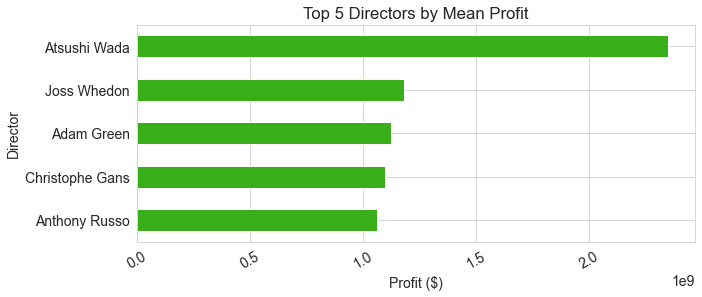

In [ ]:
top_directors_by_mean_profit.iloc[::-1].plot.barh(figsize=(10, 4), color='#38AF18')
plt.title(f'Top {n} {g.title()} by Mean Profit')
plt.xlabel('Profit ($)')
plt.ylabel('Director')
plt.xticks(rotation=30)
plt.show()

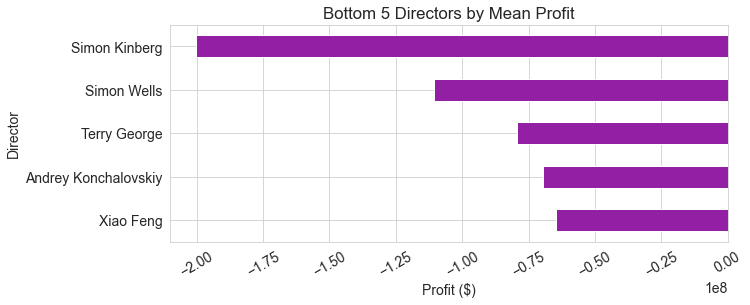

In [ ]:
bottom_directors_by_mean_profit.iloc[::-1].plot.barh(figsize=(10, 4), color='#921FA4')
plt.title(f'Bottom {n} {g.title()} by Mean Profit')
plt.xlabel('Profit ($)')
plt.ylabel('Director')
plt.xticks(rotation=30)
plt.show()

### By Total Number of Votes

In [ ]:
c2 = 'numvotes'

top_directors_by_mean_votes,\
bottom_directors_by_mean_votes = top_bottom_analysis(unique_directors_df, g, m, c2, n)

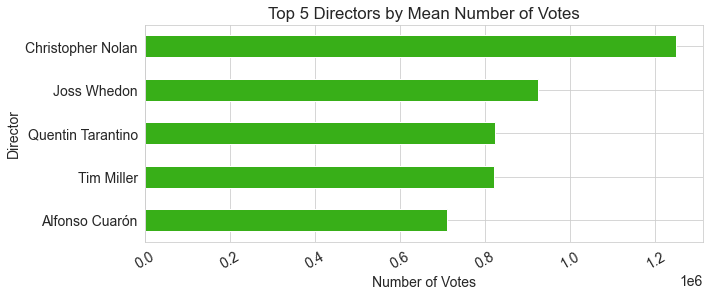

In [ ]:
top_directors_by_mean_votes.iloc[::-1].plot.barh(figsize=(10, 4), color='#38AF18')
plt.title(f'Top {n} {g.title()} by Mean Number of Votes')
plt.xlabel('Number of Votes')
plt.ylabel('Director')
plt.xticks(rotation=30)
plt.show()

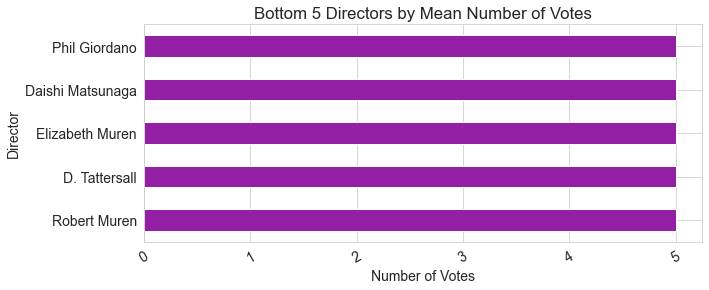

In [ ]:
bottom_directors_by_mean_votes.iloc[::-1].plot.barh(figsize=(10, 4), color='#921FA4')
plt.title(f'Bottom {n} {g.title()} by Mean Number of Votes')
plt.xlabel('Number of Votes')
plt.ylabel('Director')
plt.xticks(rotation=30)
plt.show()

## Genre Analysis

In [ ]:
unique_genres_df = unique_directors_df.explode('genres')
unique_genres_df = unique_genres_df.drop_duplicates(subset=['movie_id', 'genres'])
unique_genres_df.head(3)

,movie_id,directors,averagerating,numvotes,title,region,year,runtime_minutes,genres,production_budget,domestic_gross,foreign_gross,profit,roi
0,tt1695994,Huck Botko,4.6,3696,The Virginity Hit,HU,2010,86.0,Comedy,2000000.0,636706.0,0.0,-1363294.0,-0.681647
1,tt1289419,David M. Matthews,3.6,587,N-Secure,US,2010,105.0,Crime,1600000.0,2595644.0,0.0,995644.0,0.622278
1,tt1289419,David M. Matthews,3.6,587,N-Secure,US,2010,105.0,Drama,1600000.0,2595644.0,0.0,995644.0,0.622278


In [ ]:
g2 = 'genres'

top_genres_by_mean_profit, \
bottom_genres_by_mean_profit = top_bottom_analysis(unique_genres_df, g2, m, c, n)

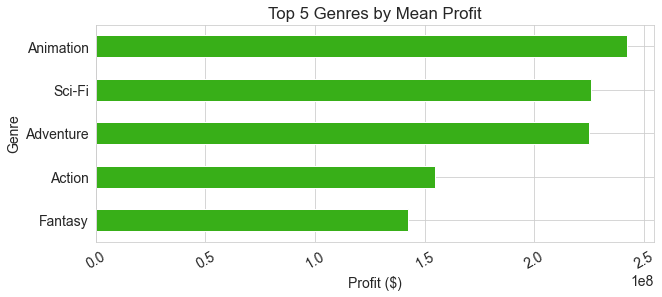

In [ ]:
top_genres_by_mean_profit.iloc[::-1].plot.barh(figsize=(10, 4), color='#38AF18')
plt.title(f'Top {n} {g2.title()} by Mean Profit')
plt.xlabel('Profit ($)')
plt.ylabel('Genre')
plt.xticks(rotation=30)
plt.show()

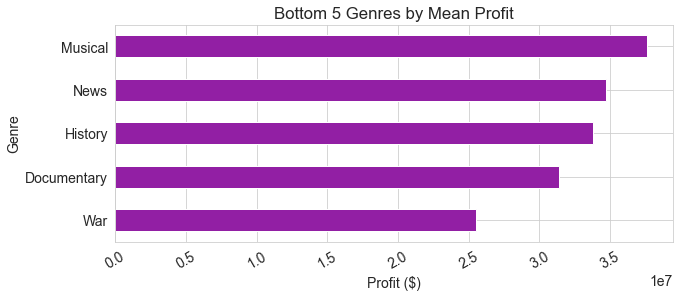

In [ ]:
bottom_genres_by_mean_profit.plot.barh(figsize=(10, 4), color='#921FA4')
plt.title(f'Bottom {n} {g2.title()} by Mean Profit')
plt.xlabel('Profit ($)')
plt.ylabel('Genre')
plt.xticks(rotation=30)
plt.show()

In [ ]:
top_genres_by_mean_votes, \
bottom_genres_by_mean_votes = top_bottom_analysis(unique_genres_df, g2, m, c2, n)

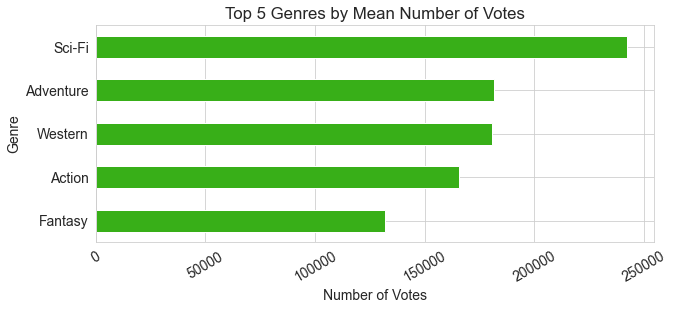

In [ ]:
top_genres_by_mean_votes.iloc[::-1].plot.barh(figsize=(10, 4), color='#38AF18')
plt.title(f'Top {n} {g2.title()} by Mean Number of Votes')
plt.xlabel('Number of Votes')
plt.ylabel('Genre')
plt.xticks(rotation=30)
plt.show()

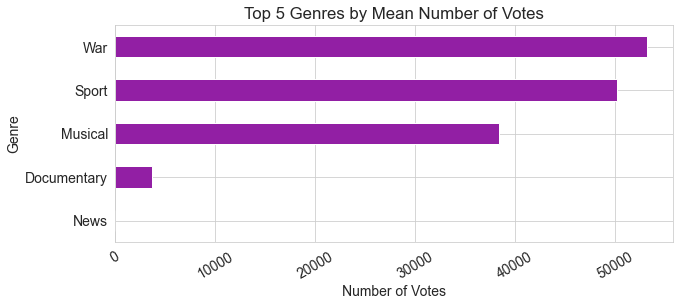

In [ ]:
bottom_genres_by_mean_votes.plot.barh(figsize=(10, 4), color='#921FA4')
plt.title(f'Top {n} {g2.title()} by Mean Number of Votes')
plt.xlabel('Number of Votes')
plt.ylabel('Genre')
plt.xticks(rotation=30)
plt.show()

## ROI Analysis

In [ ]:
highest_roi_directors, _ = top_bottom_analysis(unique_directors_df, 'directors', 'mean', 'roi', len(unique_directors_df))

In [ ]:
Q1 = highest_roi_directors.quantile(0.25)
Q3 = highest_roi_directors.quantile(0.75)
IQR = Q3 - Q1
filtered_highest_roi_directors = highest_roi_directors[(highest_roi_directors >= Q1 - 1.5*IQR) & (highest_roi_directors <= Q3 + 1.5*IQR)]
director_counts = unique_directors_df['directors'].value_counts()
directors_to_keep = director_counts[director_counts > 3].index
filtered_highest_roi_directors = filtered_highest_roi_directors[filtered_highest_roi_directors.index.isin(directors_to_keep)]
filtered_highest_roi_directors = filtered_highest_roi_directors[filtered_highest_roi_directors > 1.2]
display(filtered_highest_roi_directors.head(3))
display(filtered_highest_roi_directors.tail(3))

directors
Chris Renaud         7.487083
David O. Russell     6.365257
Steven Soderbergh    5.914333
Name: roi, dtype: float64

directors
Tyler Perry        1.337438
Martin Scorsese    1.288123
Zack Snyder        1.243864
Name: roi, dtype: float64

In [ ]:
highest_roi_genres, _ = top_bottom_analysis(unique_genres_df, 'genres', 'mean', 'roi', len(unique_genres_df))
highest_roi_genres = highest_roi_genres[highest_roi_genres > 1.2]
display(highest_roi_genres.head(3))
display(highest_roi_genres.tail(3))

genres
Mystery     8.267983
Horror      7.718993
Thriller    5.311242
Name: roi, dtype: float64

genres
Sport        2.075350
Adventure    2.070939
Crime        1.467618
Name: roi, dtype: float64

### Regression on scaled data:

In [ ]:
budget_profit_regression_df = merged_df[['production_budget', 'profit']].drop_duplicates().copy()
budget_profit_regression_df

,production_budget,profit
0,45000000.0,-4.492629e+07
50,25000000.0,-1.568670e+07
104,91000000.0,9.686118e+07
168,28000000.0,3.410859e+07
220,215000000.0,1.433855e+09
...,...,...
135870,27000000.0,-2.251452e+07
135946,75000000.0,-4.437331e+07
135949,500000.0,-1.912070e+05
135953,38000000.0,1.167840e+07


In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaled_data = scaler.fit_transform(budget_profit_regression_df['production_budget'].values.reshape(-1, 1))
X_S = scaled_data[:, 0]
y = budget_profit_regression_df['profit'].values

In [ ]:
import statsmodels.api as sm

lin_reg = sm.OLS(y, sm.add_constant(X_S)).fit()

print(f'profit change per one standard deviation increase in budget: ${lin_reg.params[1]:,.2f}')

profit change per one standard deviation increase in budget: $121,350,078.04


In [ ]:
print(lin_reg.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.446
Model:                            OLS   Adj. R-squared:                  0.445
Method:                 Least Squares   F-statistic:                     1575.
Date:                Wed, 02 Aug 2023   Prob (F-statistic):          2.56e-253
Time:                        15:31:23   Log-Likelihood:                -39519.
No. Observations:                1962   AIC:                         7.904e+04
Df Residuals:                    1960   BIC:                         7.905e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       8.111e+07   3.06e+06     26.529      0.0

In [ ]:
top_directors_by_mean_profit.to_csv('top_directors_by_mean_profit.csv')
bottom_directors_by_mean_profit.to_csv('bottom_directors_by_mean_profit.csv')

top_directors_by_mean_votes.to_csv('top_directors_by_mean_votes.csv')
bottom_directors_by_mean_votes.to_csv('bottom_directors_by_mean_votes.csv')

top_genres_by_mean_profit.to_csv('top_genres_by_mean_profit.csv')
bottom_genres_by_mean_profit.to_csv('bottom_genres_by_mean_profit.csv')

top_genres_by_mean_votes.to_csv('top_genres_by_mean_votes.csv')
bottom_genres_by_mean_votes.to_csv('bottom_genres_by_mean_votes.csv')

In [ ]:
unique_directors_df.to_csv('unique_directors.csv')
unique_genres_df.to_csv('unique_genres_df.csv')

###